In [1]:
import os
os.chdir('D:\Birkbeck\MSc Data Science\Year 2\ML\Coursework\occupancy_data')

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report


from keras.models import Sequential
from keras.layers import Dense, InputLayer, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping

In [3]:
train_file = pd.read_csv('datatraining.txt')

In [4]:
train_file.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


## Date & Time Processing

In [6]:
# date is an object in the DF - meaning a string. Change the format.
string_format = "%Y-%m-%d %H:%M:%S"
train_file.date = pd.to_datetime(train_file['date'], format = string_format)
train_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8143 non-null   datetime64[ns]
 1   Temperature    8143 non-null   float64       
 2   Humidity       8143 non-null   float64       
 3   Light          8143 non-null   float64       
 4   CO2            8143 non-null   float64       
 5   HumidityRatio  8143 non-null   float64       
 6   Occupancy      8143 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 508.9 KB


In [7]:
train_file.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [8]:
#Checking the date range
train_file['date'].min(), train_file['date'].max()

(Timestamp('2015-02-04 17:51:00'), Timestamp('2015-02-10 09:33:00'))

In [9]:
# Add columns for the time in seconds(since midnight at 00.) and whether the day is a weekend or week day

train_file['seconds'] = train_file.date.dt.second + ((train_file.date.dt.minute)*60)+((train_file.date.dt.hour)*3600)
train_file['day'] = train_file.date.dt.weekday

train_file.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,seconds,day
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,64260,2
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,64319,2
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,64380,2
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,64440,2
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,64500,2


* NOTE: Dates range from 4th Feb 2015 to 10th Feb 2015, a 7 day period.

In [10]:
train_file['weekday'] = train_file.day.apply(lambda x: 1 if x <= 4 else 0)
train_file['weekday'].value_counts()

1    5263
0    2880
Name: weekday, dtype: int64

In [11]:
train_file.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,seconds,day,weekday
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1,34140,1,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1,34199,1,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1,34259,1,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1,34320,1,1
8143,2015-02-10 09:33:00,21.10,36.2000,447.0,821.000000,0.005612,1,34380,1,1


In [12]:
# Move occupancy, as the target variable, to the last column.
last_column = train_file.pop('Occupancy')

train_file.insert(9, 'Occupancy', last_column)
train_file.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,seconds,day,weekday,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,64260,2,1,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,64319,2,1,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,64380,2,1,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,64440,2,1,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,64500,2,1,1


In [13]:
# check for missing values
train_file.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
seconds          0
day              0
weekday          0
Occupancy        0
dtype: int64

In [14]:
#check for null values too
train_file.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
seconds          0
day              0
weekday          0
Occupancy        0
dtype: int64

## Exploratory Data Analysis

In [15]:
train_file.groupby('Occupancy').size()

Occupancy
0    6414
1    1729
dtype: int64

In [16]:
print(6414/8143)
print(1729/8143)

0.7876703917475132
0.2123296082524868


In [17]:
train_file.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,seconds,day,weekday,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,42794.329608,3.344222,0.646322,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,25556.911034,2.067996,0.478140,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000,0.000000,0.000000,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,20339.000000,2.000000,0.000000,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,41939.000000,4.000000,1.000000,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,66000.000000,5.000000,1.000000,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,86339.000000,6.000000,1.000000,1.000000


In [18]:
corr = train_file.corr()
corr

,Temperature,Humidity,Light,CO2,HumidityRatio,seconds,day,weekday,Occupancy
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,0.259958,-0.236655,0.418657,0.538220
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,0.016974,-0.456780,0.108551,0.132964
Light,0.649942,0.037828,1.000000,0.664022,0.230420,0.085417,-0.160210,0.279519,0.907352
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,0.209348,-0.472879,0.394834,0.712235
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,0.095987,-0.537909,0.243146,0.300282
seconds,0.259958,0.016974,0.085417,0.209348,0.095987,1.000000,0.044203,-0.010865,0.080198
day,-0.236655,-0.456780,-0.160210,-0.472879,-0.537909,0.044203,1.000000,-0.771188,-0.251973
weekday,0.418657,0.108551,0.279519,0.394834,0.243146,-0.010865,-0.771188,1.000000,0.384072
Occupancy,0.538220,0.132964,0.907352,0.712235,0.300282,0.080198,-0.251973,0.384072,1.000000


In [19]:
corr['Occupancy'].sort_values(ascending = False)

Occupancy        1.000000
Light            0.907352
CO2              0.712235
Temperature      0.538220
weekday          0.384072
HumidityRatio    0.300282
Humidity         0.132964
seconds          0.080198
day             -0.251973
Name: Occupancy, dtype: float64

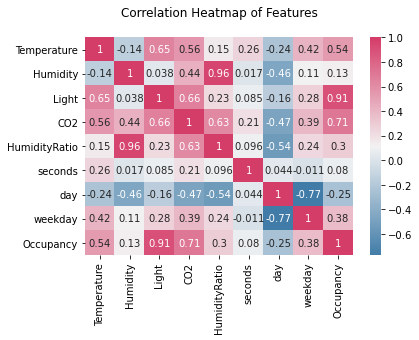

In [125]:
cmap = sns.diverging_palette(240, 0, as_cmap=True)
sns.heatmap(corr, annot = True, cmap = cmap)
plt.title('Correlation Heatmap of Features\n')
plt.show()

C:\Users\Michelle Bark\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


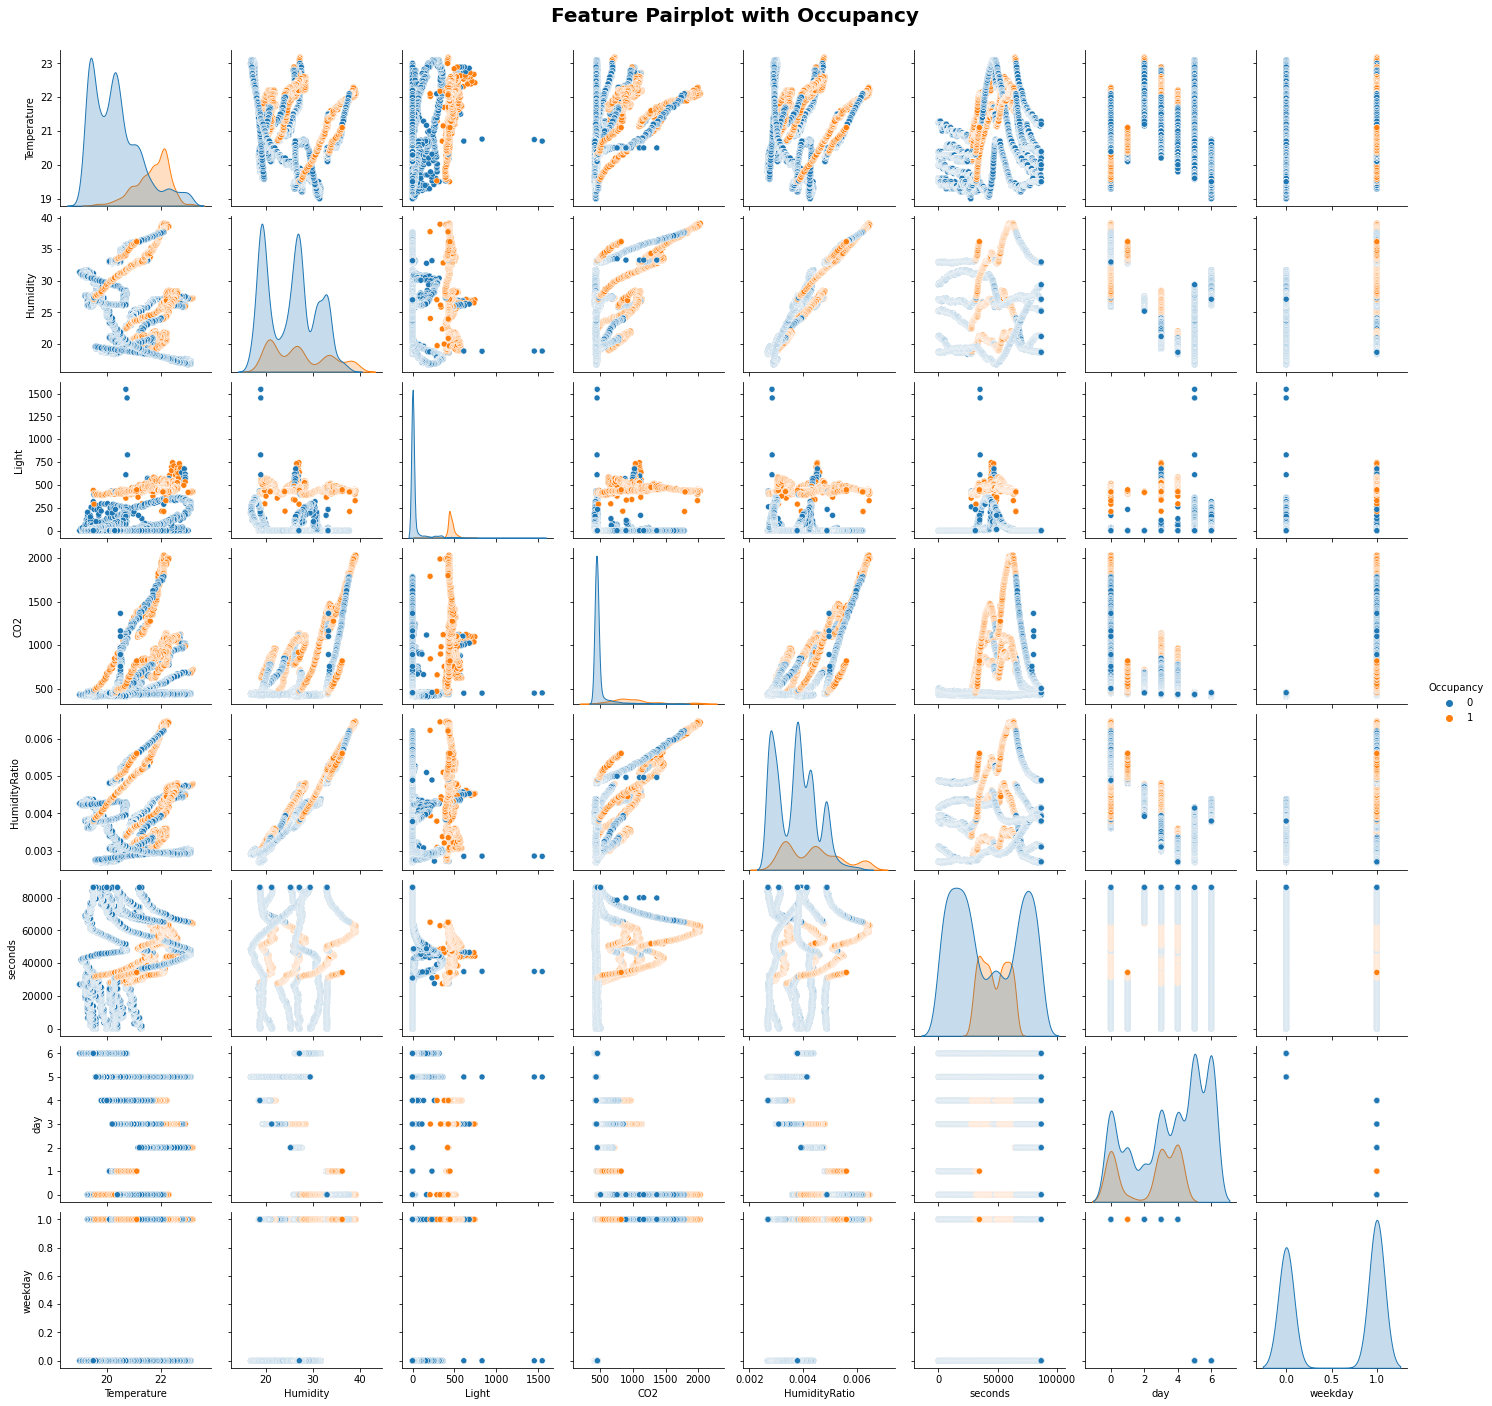

In [21]:
p = sns.pairplot(train_file, hue = 'Occupancy')
plt.subplots_adjust(top = 0.95)
plt.suptitle('Feature Pairplot with Occupancy ', fontsize = 20, fontweight = 'bold' )
plt.show()

#### Notes/Observations: 

-  Outliers in the light feature - when room is unoccupied.
-  The long tail/skew in the CO2 density plot indicates outliers. 
-  Light has more obvious separability between the classes
-  Can see differences offered by the seconds (time of the day) and day features.
-  Consider - day as numbered in order but not an ordinal feature - may need to remove to one hot encode
-  Humidity and humidity ratio are highly correlated. 
-  Humidity could be removed, humidy ratio has better correlation to the target

## Pre-processing

In [22]:
#Remove the day column. Doesn't appear to be offering more information than the weekday column
#Could onehotencode to see if specific days do make a difference - later development/exploration
#date also dropped as covered by seconds and weekday

train_file = train_file.drop(columns = ['day', 'date'])
train_file.describe()


,Temperature,Humidity,Light,CO2,HumidityRatio,seconds,weekday,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,42794.329608,0.646322,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,25556.911034,0.478140,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000,0.000000,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,20339.000000,0.000000,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,41939.000000,1.000000,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,66000.000000,1.000000,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,86339.000000,1.000000,1.000000


In [23]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   seconds        8143 non-null   int64  
 6   weekday        8143 non-null   int64  
 7   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 572.6 KB


In [24]:
#splitting the training set into train and validation set for assessment of NN including early stopping. 
array = train_file.values
X = array[ : , 0:7]
y = array[ : , 7]

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state = 3)
X_train.shape

(6514, 7)

In [25]:
# Scale the data for use in a NN, with MinMax scaling. Transform both train and validation. 

MM_scaler = MinMaxScaler()
X_train_MM = MM_scaler.fit(X_train)
X_train_MM = MM_scaler.transform(X_train)
X_valid_MM = MM_scaler.transform(X_valid)


## Building the Neural Network

### Grid Search for the Number of Layers and Neurons per Layer

In [81]:
# Creating an initial Neural Network - searching for no of layers and neurons.
# other parameters set the same, relu, sigmoid, adam on MinMax scaled data

def model_builder(n_hidden = 1, n_neurons = 5, init = 'he_normal'):
    model = Sequential()
    model.add(Dense(10, input_dim = 7, activation = 'relu', kernel_initializer = init))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'relu', kernel_initializer = init))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


#call the functionto create the model
model_a = KerasClassifier(model_builder, verbose = 0)

#search parameters
n_hidden = [1,2,3,4]
n_neurons = [6,8,10,12]
param_grid = dict(n_hidden=n_hidden, n_neurons=n_neurons)
grid = GridSearchCV(estimator=model_a, param_grid=param_grid, verbose=1, cv=KFold(5, random_state = 3, shuffle = True))
grid_result = grid.fit(X_train_MM, y_train,
                       validation_data = (X_valid_MM, y_valid), 
                       callbacks = [EarlyStopping(patience = 10)])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [82]:
#output results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.912967 using {'n_hidden': 4, 'n_neurons': 10}

0.810716 (0.058621) with: {'n_hidden': 1, 'n_neurons': 6}
0.834354 (0.058576) with: {'n_hidden': 1, 'n_neurons': 8}
0.795828 (0.026237) with: {'n_hidden': 1, 'n_neurons': 10}
0.815321 (0.054636) with: {'n_hidden': 1, 'n_neurons': 12}
0.786311 (0.020020) with: {'n_hidden': 2, 'n_neurons': 6}
0.786311 (0.020020) with: {'n_hidden': 2, 'n_neurons': 8}
0.811810 (0.067655) with: {'n_hidden': 2, 'n_neurons': 10}
0.870756 (0.082341) with: {'n_hidden': 2, 'n_neurons': 12}
0.849243 (0.066641) with: {'n_hidden': 3, 'n_neurons': 6}
0.856764 (0.091853) with: {'n_hidden': 3, 'n_neurons': 8}
0.858606 (0.083546) with: {'n_hidden': 3, 'n_neurons': 10}
0.870736 (0.072709) with: {'n_hidden': 3, 'n_neurons': 12}
0.786311 (0.020020) with: {'n_hidden': 4, 'n_neurons': 6}
0.860319 (0.075281) with: {'n_hidden': 4, 'n_neurons': 8}
0.912967 (0.074365) with: {'n_hidden': 4, 'n_neurons': 10}
0.886409 (0.098066) with: {'n_hidden': 4, 'n_neurons': 12}


In [94]:
resultsdf = pd.DataFrame(grid.cv_results_)
results_out = resultsdf[resultsdf.columns[6:13]]
#results_out.to_csv('ML grid search 1.csv')

### Build NN with Epochs and Batches Using Early Stopping

In [29]:
# Build the model as ouput from search.All other parameters the same
# Now add epochs and batches to train.
# this model builder is set in order to use for seraching further parameters

def model_builder_two(opt = 'adam', init = 'he_normal',activ = 'relu', verbose = 1):
    model = Sequential()
    model.add(Dense(10, input_dim = 7, activation = activ, kernel_initializer = init))
    model.add(Dense(10, activation = activ, kernel_initializer = init))
    model.add(Dense(10, activation = activ, kernel_initializer = init))
    model.add(Dense(10, activation = activ, kernel_initializer = init))
    model.add(Dense(10, activation = activ, kernel_initializer = init))  
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
    return model

#call the functionto create the model, change verbose argument to see output of epochs
model_b = model_builder_two(verbose = 0)

#fit the model to the data
history = model_b.fit(X_train_MM, y_train, 
          validation_data = (X_valid_MM, y_valid), 
          epochs = 300, 
          batch_size = 20,
          callbacks = [EarlyStopping(patience = 10)])

Epoch 1/300
326/326 [==============================] - 5s 13ms/step - loss: 0.2907 - accuracy: 0.9234 - val_loss: 0.0715 - val_accuracy: 0.9847
Epoch 2/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0486 - accuracy: 0.9891 - val_loss: 0.0577 - val_accuracy: 0.9847
Epoch 3/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0432 - accuracy: 0.9896 - val_loss: 0.0554 - val_accuracy: 0.9847
Epoch 4/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0409 - accuracy: 0.9897 - val_loss: 0.0559 - val_accuracy: 0.9847
Epoch 5/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0403 - accuracy: 0.9900 - val_loss: 0.0552 - val_accuracy: 0.9853
Epoch 6/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0388 - accuracy: 0.9899 - val_loss: 0.0541 - val_accuracy: 0.9853
Epoch 7/300
326/326 [==============================] - 4s 12ms/step - loss: 0.0384 - accuracy: 0.9899 - val_loss: 0.0533 - val_accuracy:

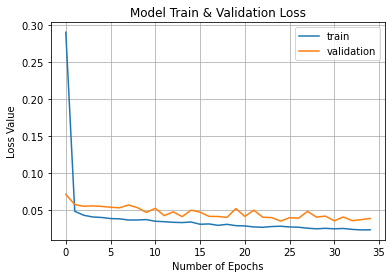

In [30]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')

plt.grid(True)
plt.title('Model Train & Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()         

In [31]:
train_loss, train_acc =model_b.evaluate(X_train_MM, y_train)
val_loss, val_acc = model_b.evaluate(X_valid_MM, y_valid)

51/51 [==============================] - 0s 6ms/step - loss: 0.0389 - accuracy: 0.9822


Accuracy is good, better than the search output for finding the layers and number of neurons but possibly overfitting. Loss on the validation set is also good.
Next : tune optimiser, initaliser and activation functions for layers (not output layer)

### Tune the Optimiser, Kernel Initialiser and the Activation function

In [106]:
# use grid search for tuning optimiser as fewer parameters to search
# using default learning rate of 0.001 for adam and nadam


model_c = KerasClassifier(model_builder_two,verbose = 0)

#search parameters
opt = ['adam','nadam']
init = ['he_normal', 'lecun_normal']
activ = ['relu', 'selu']

param_grid = dict(opt = opt, init = init, activ = activ)
grid2 = GridSearchCV(estimator=model_c, param_grid=param_grid, verbose=1, cv=KFold(5, random_state = 3, shuffle = True))
grid2_result = grid2.fit(X_train_MM, y_train,
                       validation_data = (X_valid_MM, y_valid),
                       callbacks = [EarlyStopping(patience = 10)])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [107]:

#output results
print("Best: %f using %s" % (grid2_result.best_score_, grid2_result.best_params_))
print()
means = grid2_result.cv_results_['mean_test_score']
stds = grid2_result.cv_results_['std_test_score']
params = grid2_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.979122 using {'activ': 'selu', 'init': 'he_normal', 'opt': 'adam'}

0.931371 (0.034248) with: {'activ': 'relu', 'init': 'he_normal', 'opt': 'adam'}
0.884713 (0.071077) with: {'activ': 'relu', 'init': 'he_normal', 'opt': 'nadam'}
0.856457 (0.082683) with: {'activ': 'relu', 'init': 'lecun_normal', 'opt': 'adam'}
0.913273 (0.067223) with: {'activ': 'relu', 'init': 'lecun_normal', 'opt': 'nadam'}
0.979122 (0.011804) with: {'activ': 'selu', 'init': 'he_normal', 'opt': 'adam'}
0.977894 (0.009856) with: {'activ': 'selu', 'init': 'he_normal', 'opt': 'nadam'}
0.978201 (0.003901) with: {'activ': 'selu', 'init': 'lecun_normal', 'opt': 'adam'}
0.976359 (0.007382) with: {'activ': 'selu', 'init': 'lecun_normal', 'opt': 'nadam'}


In [108]:
resultsdf2 = pd.DataFrame(grid2.cv_results_)
results_out2 = resultsdf2[resultsdf2.columns[6:13]]
results_out2.to_csv('ML grid search 2.csv')

Results show that adam as the optimizer and kernel initialiser he_normal with selu as activation function on the hidden layers, as performing the best according to the grid search. 


## Build Model with Tuned Parameters

In [109]:
#now build the resulting model and train with 300 epochs, batch size 20 and early stopping as regularization

model_d = model_builder_two(opt = 'adam', init = 'he_normal',activ = 'selu', verbose = 0)

history = model_d.fit(X_train_MM, y_train, 
          validation_data = (X_valid_MM, y_valid), 
          epochs = 300, 
          batch_size = 20,
          callbacks = [EarlyStopping(patience = 10)])

Epoch 1/300
326/326 [==============================] - 5s 14ms/step - loss: 0.1052 - accuracy: 0.9711 - val_loss: 0.0590 - val_accuracy: 0.9828
Epoch 2/300
326/326 [==============================] - 4s 13ms/step - loss: 0.0420 - accuracy: 0.9897 - val_loss: 0.0549 - val_accuracy: 0.9847
Epoch 3/300
326/326 [==============================] - 4s 13ms/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.0537 - val_accuracy: 0.9847
Epoch 4/300
326/326 [==============================] - 6s 17ms/step - loss: 0.0383 - accuracy: 0.9897 - val_loss: 0.0510 - val_accuracy: 0.9853
Epoch 5/300
326/326 [==============================] - 6s 19ms/step - loss: 0.0383 - accuracy: 0.9896 - val_loss: 0.0490 - val_accuracy: 0.9853
Epoch 6/300
326/326 [==============================] - 5s 15ms/step - loss: 0.0366 - accuracy: 0.9900 - val_loss: 0.0485 - val_accuracy: 0.9853
Epoch 7/300
326/326 [==============================] - 4s 13ms/step - loss: 0.0356 - accuracy: 0.9896 - val_loss: 0.0442 - val_accuracy:

In [110]:
train_loss, train_acc =model_d.evaluate(X_train_MM, y_train)
val_loss, val_acc = model_d.evaluate(X_valid_MM, y_valid)

51/51 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.9847


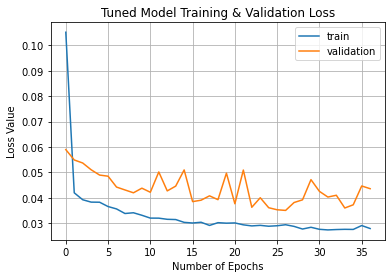

In [112]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')

plt.grid(True)
plt.title('Tuned Model Training & Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()         

Validation loss bounces around a lot, but under 0.05. 

Apply model to test set. Must first transform the data in the same ways:
 - add time and weekend features
 - remove date and weekday feature
 - scale using MinMaxScaler

## Apply to the Test Sets

### Preprocessing the Test Sets

In [113]:
# read in files
test_1_file = pd.read_csv('datatest.txt')
test_2_file = pd.read_csv('datatest2.txt')

# change date format
test_1_file.date = pd.to_datetime(test_1_file['date'], format = string_format)
test_2_file.date = pd.to_datetime(test_2_file['date'], format = string_format)

# convert seconds and day
test_1_file['seconds'] = test_1_file.date.dt.second + ((test_1_file.date.dt.minute)*60)+((test_1_file.date.dt.hour)*3600)
test_1_file['day'] = test_1_file.date.dt.weekday

test_2_file['seconds'] = test_2_file.date.dt.second + ((test_2_file.date.dt.minute)*60)+((test_2_file.date.dt.hour)*3600)
test_2_file['day'] = test_2_file.date.dt.weekday


# make weekday feature
test_1_file['weekday'] = test_1_file.day.apply(lambda x: 1 if x <= 4 else 0)
test_2_file['weekday'] = test_2_file.day.apply(lambda x: 1 if x <= 4 else 0)

#move target to last column (not 100% necessary, but easier for splitting into train and test) & drop columns
last_column1 = test_1_file.pop('Occupancy')
test_1_file.insert(9, 'Occupancy', last_column1)
test_1_file = test_1_file.drop(columns = ['day', 'date'])

last_column2 = test_2_file.pop('Occupancy')
test_2_file.insert(9, 'Occupancy', last_column2)
test_2_file = test_2_file.drop(columns = ['day', 'date'])

#check
print(test_1_file.info())
print(test_2_file.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    2665 non-null   float64
 1   Humidity       2665 non-null   float64
 2   Light          2665 non-null   float64
 3   CO2            2665 non-null   float64
 4   HumidityRatio  2665 non-null   float64
 5   seconds        2665 non-null   int64  
 6   weekday        2665 non-null   int64  
 7   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 187.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    9752 non-null   float64
 1   Humidity       9752 non-null   float64
 2   Light          9752 non-null   float64
 3   CO2            9752 non-null   float64
 4   HumidityRatio  9752 

In [114]:
#splitting the test set into X and y
array = test_1_file.values
X_t1 = array[ : , 0:7]
y_t1 = array[ : , 7]

array = test_2_file.values
X_t2 = array[ : , 0:7]
y_t2 = array[ : , 7]

#scale test sets
X_test_1 = MM_scaler.transform(X_t1)
X_test_2 = MM_scaler.transform(X_t2)

#checking

print(X_test_1.shape)
print(X_test_2.shape)

(2665, 7)
(9752, 7)


In [115]:
model_d.evaluate(X_test_1, y_t1)

84/84 [==============================] - 1s 6ms/step - loss: 0.2250 - accuracy: 0.9118


[0.22497506439685822, 0.9118198752403259]

In [116]:
model_d.evaluate(X_test_2, y_t2)

305/305 [==============================] - 2s 6ms/step - loss: 0.2405 - accuracy: 0.9226


[0.24048137664794922, 0.9225800037384033]

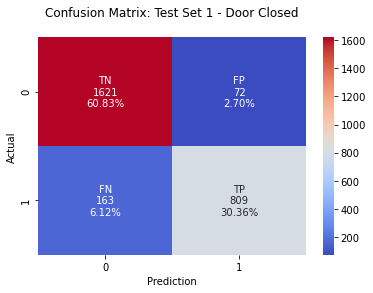

In [117]:
#apply model to predict test 1:
test1_pred = (model_d.predict(X_test_1)>0.5).astype('int32')

test1_matrix = confusion_matrix(y_t1, test1_pred)

def conf_matrix_builder(matrix_name, matrix_title):
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in matrix_name.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in matrix_name.flatten()/np.sum(matrix_name)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix_name, annot=labels, fmt='', cmap='coolwarm')
    ax.set_title('Confusion Matrix: '+ matrix_title+ '\n')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    return plt.show()
                         
conf_matrix_builder(test1_matrix, 'Test Set 1 - Door Closed')

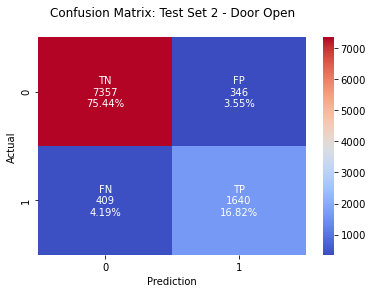

In [118]:
#apply model to predict test 2:
test2_pred = (model_d.predict(X_test_2)>0.5).astype('int32')

test2_matrix = confusion_matrix(y_t2, test2_pred)

conf_matrix_builder(test2_matrix, 'Test Set 2 - Door Open')

### Comparison to the first model built, before complete tuning

In [126]:
model_b.evaluate(X_test_1, y_t1)
model_b.evaluate(X_test_2, y_t2)

305/305 [==============================] - 2s 6ms/step - loss: 0.1005 - accuracy: 0.9508


[0.1005462110042572, 0.9507793188095093]

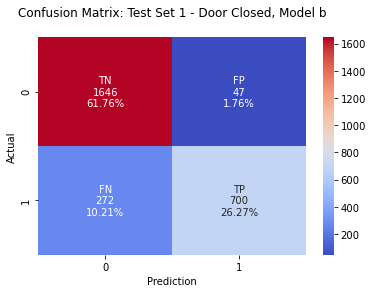

In [119]:
test1_pred_b = (model_b.predict(X_test_1)>0.5).astype('int32')

test1_matrix_b = confusion_matrix(y_t1, test1_pred_b)

conf_matrix_builder(test1_matrix_b, 'Test Set 1 - Door Closed, Model b')

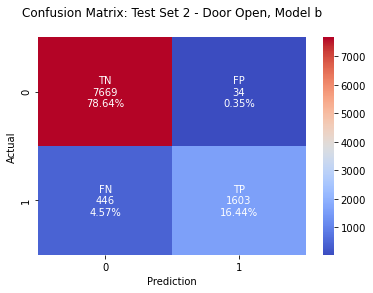

In [120]:
test2_pred_b = (model_b.predict(X_test_2)>0.5).astype('int32')

test2_matrix_b = confusion_matrix(y_t2, test2_pred_b)

conf_matrix_builder(test2_matrix_b, 'Test Set 2 - Door Open, Model b')

## Using Drop Out for Regularisation

In [121]:
# Same model parameters except Dropout used for regularisation
opt = 'nadam'
init = 'lecun_normal'
activ = 'selu'
model_e = Sequential()
model_e.add(Dense(10, input_dim = 7, activation = activ, kernel_initializer = init))
model_e.add(Dropout(rate = 0.2))
model_e.add(Dense(10, activation = activ, kernel_initializer = init))
model_e.add(Dropout(rate = 0.2))
model_e.add(Dense(10, activation = activ, kernel_initializer = init))
model_e.add(Dropout(rate = 0.2))
model_e.add(Dense(10, activation = activ, kernel_initializer = init))
model_e.add(Dropout(rate = 0.2))
model_e.add(Dense(10, activation = activ, kernel_initializer = init))
model_e.add(Dropout(rate = 0.2))
model_e.add(Dense(1, activation = 'sigmoid'))
    
model_e.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


history = model_e.fit(X_train_MM, y_train, 
          validation_data = (X_valid_MM, y_valid), 
          epochs = 100, 
          batch_size = 20)

Epoch 1/100
326/326 [==============================] - 11s 25ms/step - loss: 0.5101 - accuracy: 0.7665 - val_loss: 0.1680 - val_accuracy: 0.9484
Epoch 2/100
326/326 [==============================] - 8s 25ms/step - loss: 0.2315 - accuracy: 0.9076 - val_loss: 0.0991 - val_accuracy: 0.9699
Epoch 3/100
326/326 [==============================] - 8s 25ms/step - loss: 0.1439 - accuracy: 0.9501 - val_loss: 0.0887 - val_accuracy: 0.9742
Epoch 4/100
326/326 [==============================] - 8s 25ms/step - loss: 0.1104 - accuracy: 0.9655 - val_loss: 0.0753 - val_accuracy: 0.9804
Epoch 5/100
326/326 [==============================] - 8s 25ms/step - loss: 0.0889 - accuracy: 0.9751 - val_loss: 0.0722 - val_accuracy: 0.9822
Epoch 6/100
326/326 [==============================] - 8s 25ms/step - loss: 0.0778 - accuracy: 0.9797 - val_loss: 0.0708 - val_accuracy: 0.9840
Epoch 7/100
326/326 [==============================] - 8s 25ms/step - loss: 0.0687 - accuracy: 0.9823 - val_loss: 0.0655 - val_accuracy

In [122]:
train_loss, train_acc =model_e.evaluate(X_train_MM, y_train)
val_loss, val_acc = model_e.evaluate(X_valid_MM, y_valid)
model_e.evaluate(X_test_1, y_t1)
model_e.evaluate(X_test_2, y_t2)

305/305 [==============================] - 2s 6ms/step - loss: 0.0498 - accuracy: 0.9907


[0.04976130276918411, 0.9906685948371887]

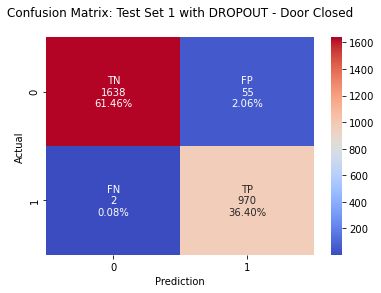

In [123]:
test1_pred = (model_e.predict(X_test_1)>0.5).astype('int32')

test1_matrix_e = confusion_matrix(y_t1, test1_pred)

                         
conf_matrix_builder(test1_matrix_e, 'Test Set 1 with DROPOUT - Door Closed')

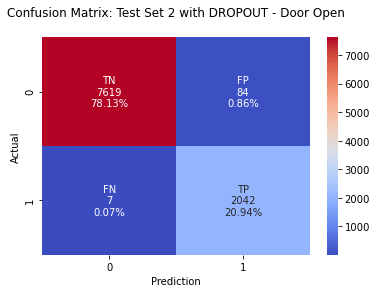

In [124]:
test2_pred = (model_e.predict(X_test_2)>0.5).astype('int32')

test2_matrix_e = confusion_matrix(y_t2, test2_pred)

conf_matrix_builder(test2_matrix_e, 'Test Set 2 with DROPOUT - Door Open')

*** THE END***